100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

torch.Size([50000, 3, 32, 32])

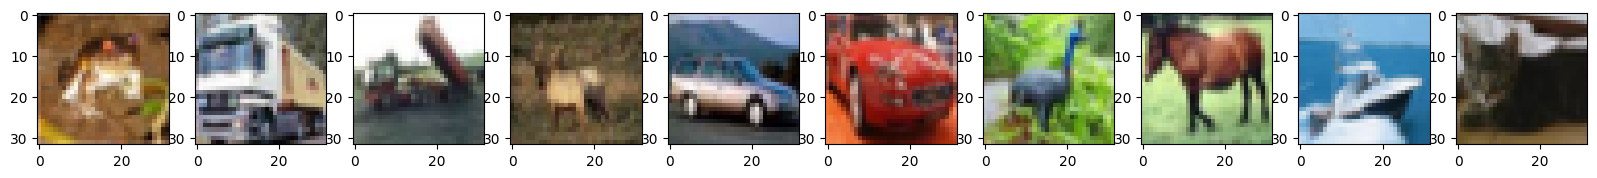

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
from torchvision.models import resnet18

CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

len(y_train), len(y_test)

X_train.min(), X_train.max()

X_train /= 255.
X_test /= 255.

CIFAR_train.classes

import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

X_train.shape, y_train.shape

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

X_train.shape

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ResNet18 = resnet18(pretrained=False, num_classes=10).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    batch_size = 70

    test_accuracy_history = []
    test_loss_history = []
    train_accuracy_history = []
    train_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        with torch.no_grad():
          test_preds = net.forward(X_test)
          test_loss_history.append(loss(test_preds, y_test).data.cpu())

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
          test_accuracy_history.append(accuracy)

          train_preds = net.forward(X_train)
          train_loss_history.append(loss(train_preds, y_train).data.cpu())

          accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().data.cpu()
          train_accuracy_history.append(accuracy)

          print(f'Эпоха №{epoch + 1}, точность на тестовых данных: {test_accuracy_history[-1]}, ошибка на тестовых данных: {test_loss_history[-1]}')
    print('---------------')
    return test_accuracy_history, test_loss_history, train_accuracy_history, train_loss_history

accuracies_test = {}
losses_test = {}
accuracies_train = {}
losses_train = {}


accuracies_test['ResNet18'], losses_test['ResNet18'], accuracies_train['ResNet18'], losses_train['ResNet18'] = \
    train(ResNet18, X_train, y_train, X_test, y_test)



Эпоха №1, точность на тестовых данных: 0.5051000118255615, ошибка на тестовых данных: 1.418476939201355
Эпоха №2, точность на тестовых данных: 0.5500999689102173, ошибка на тестовых данных: 1.38400399684906
Эпоха №3, точность на тестовых данных: 0.6728000044822693, ошибка на тестовых данных: 0.9412904381752014
Эпоха №4, точность на тестовых данных: 0.6521999835968018, ошибка на тестовых данных: 1.0555709600448608
Эпоха №5, точность на тестовых данных: 0.6898999810218811, ошибка на тестовых данных: 0.923592746257782
Эпоха №6, точность на тестовых данных: 0.6979999542236328, ошибка на тестовых данных: 0.9320187568664551
Эпоха №7, точность на тестовых данных: 0.7343999743461609, ошибка на тестовых данных: 0.8188477158546448
Эпоха №8, точность на тестовых данных: 0.6997999548912048, ошибка на тестовых данных: 1.002410888671875
Эпоха №9, точность на тестовых данных: 0.7505999803543091, ошибка на тестовых данных: 0.8675401210784912
Эпоха №10, точность на тестовых данных: 0.7599999904632568, 

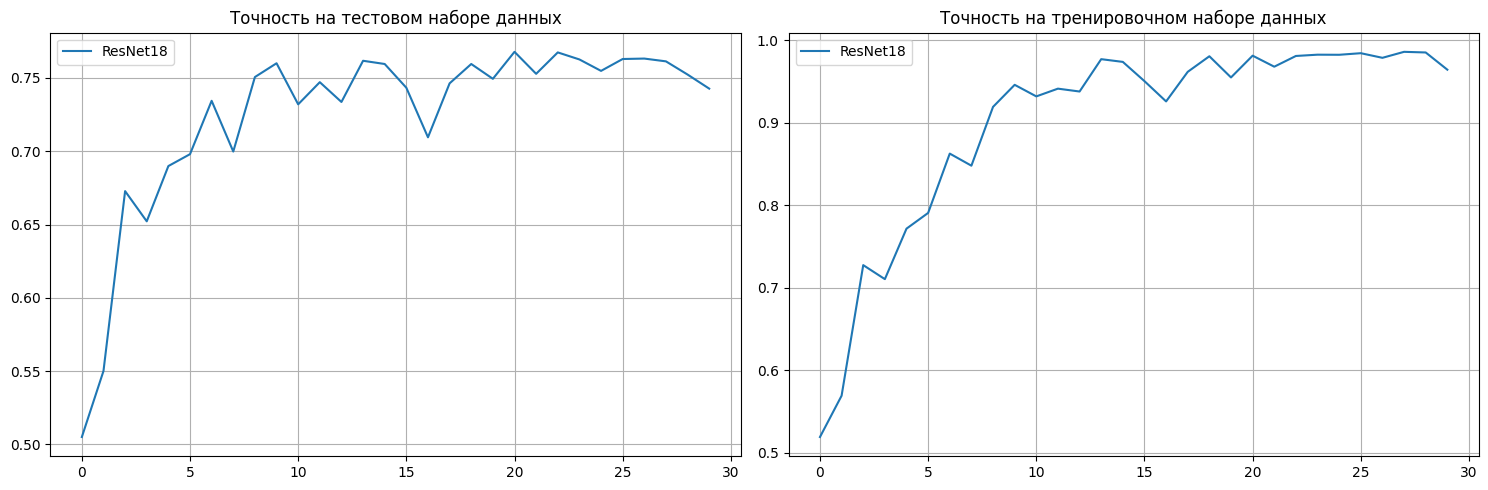

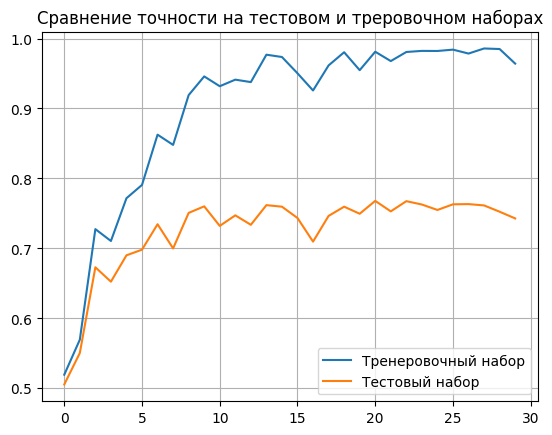

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Точность на тестовом наборе данных')
for experiment_id in accuracies_test.keys():
    axes[0].plot(accuracies_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Точность на тренировочном наборе данных')
for experiment_id in accuracies_train.keys():
    axes[1].plot(accuracies_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение точности на тестовом и треровочном наборах')
plt.plot(accuracies_train["ResNet18"], label="Тренеровочный набор")
plt.plot(accuracies_test["ResNet18"], label="Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

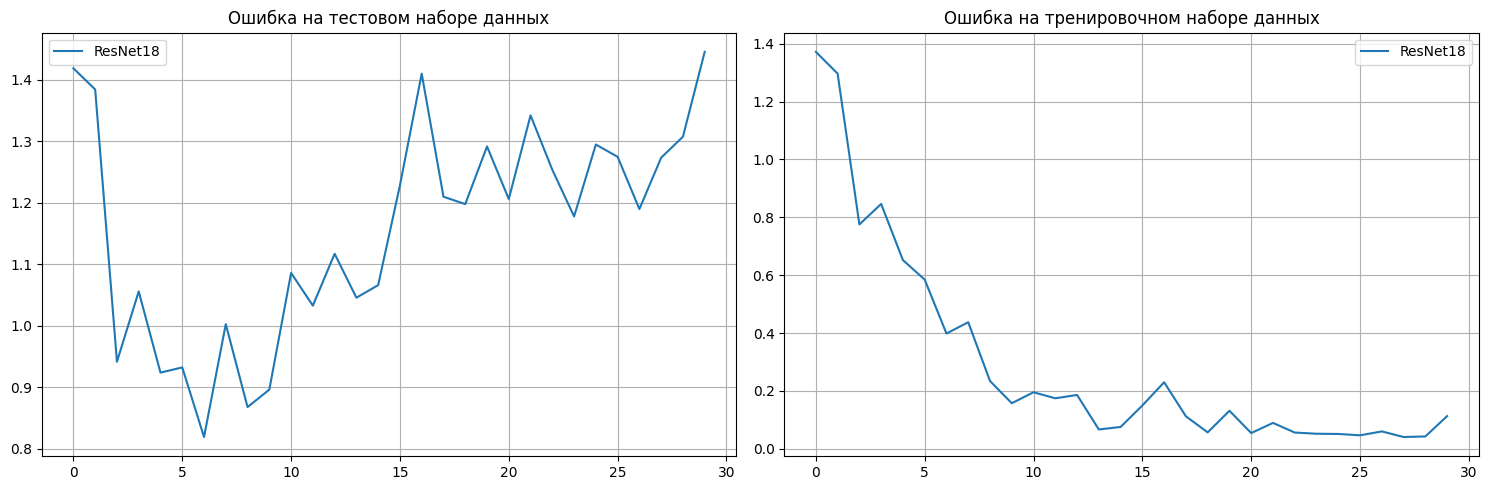

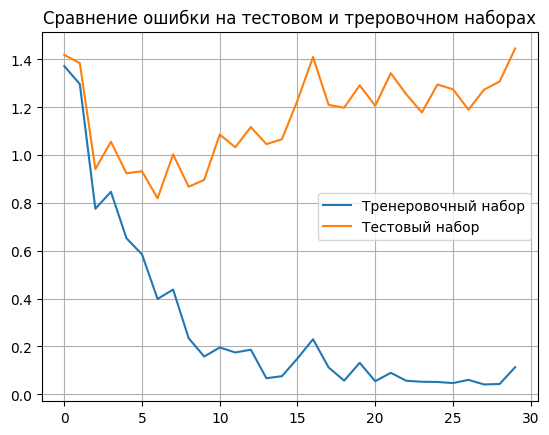

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Ошибка на тестовом наборе данных')
for experiment_id in losses_test.keys():
    axes[0].plot(losses_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Ошибка на тренировочном наборе данных')
for experiment_id in losses_train.keys():
    axes[1].plot(losses_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение ошибки на тестовом и треровочном наборах')
plt.plot(losses_train["ResNet18"], label="Тренеровочный набор")
plt.plot(losses_test["ResNet18"], label="Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)

        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)

        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)

        self.fc3   = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)

        return x

In [ ]:
accuracies_test['cifar_net'], losses_test['cifar_net'], accuracies_train['cifar_net'], losses_train['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)

Эпоха №1, точность на тестовых данных: 0.6561999917030334, ошибка на тестовых данных: 0.9776548743247986
Эпоха №2, точность на тестовых данных: 0.696399986743927, ошибка на тестовых данных: 0.8712955117225647
Эпоха №3, точность на тестовых данных: 0.7081999778747559, ошибка на тестовых данных: 0.8419342041015625
Эпоха №4, точность на тестовых данных: 0.7170999646186829, ошибка на тестовых данных: 0.8248108625411987
Эпоха №5, точность на тестовых данных: 0.7231000065803528, ошибка на тестовых данных: 0.8484691381454468
Эпоха №6, точность на тестовых данных: 0.7166999578475952, ошибка на тестовых данных: 0.8710647225379944
Эпоха №7, точность на тестовых данных: 0.7195000052452087, ошибка на тестовых данных: 0.8780690431594849
Эпоха №8, точность на тестовых данных: 0.7247999906539917, ошибка на тестовых данных: 0.935444712638855
Эпоха №9, точность на тестовых данных: 0.7120999693870544, ошибка на тестовых данных: 1.005496621131897
Эпоха №10, точность на тестовых данных: 0.7129999995231628

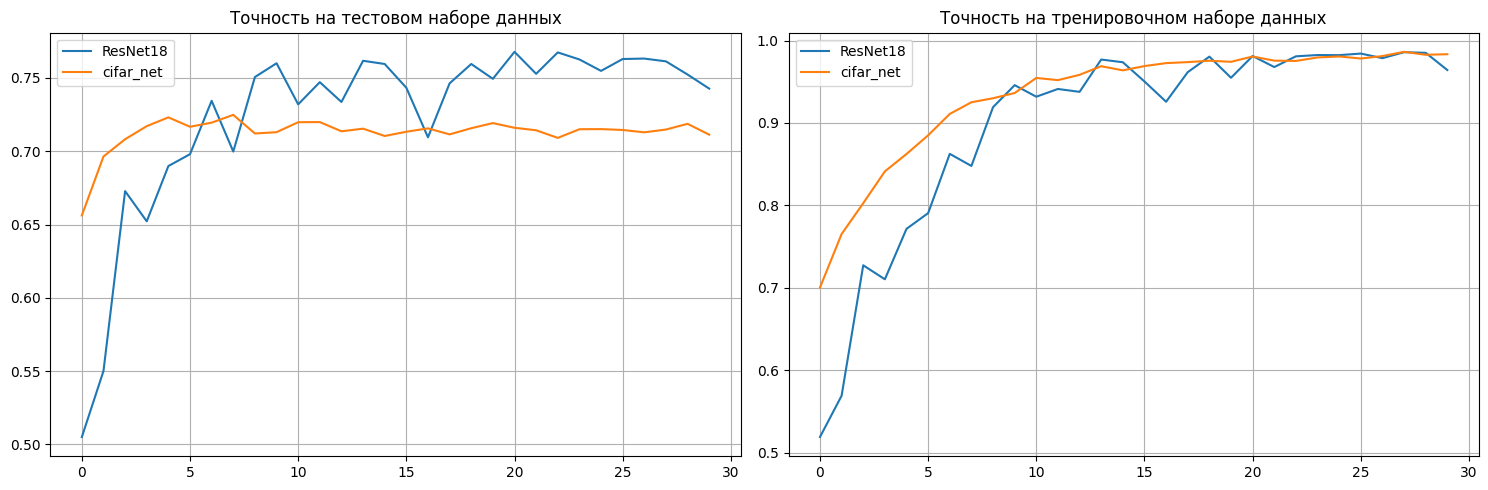

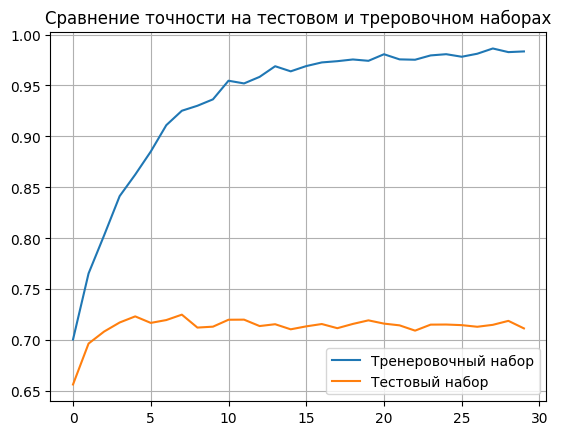

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Точность на тестовом наборе данных')
for experiment_id in accuracies_test.keys():
    axes[0].plot(accuracies_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Точность на тренировочном наборе данных')
for experiment_id in accuracies_train.keys():
    axes[1].plot(accuracies_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение точности на тестовом и треровочном наборах')
plt.plot(accuracies_train["cifar_net"], label="Тренеровочный набор")
plt.plot(accuracies_test["cifar_net"], label="Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()

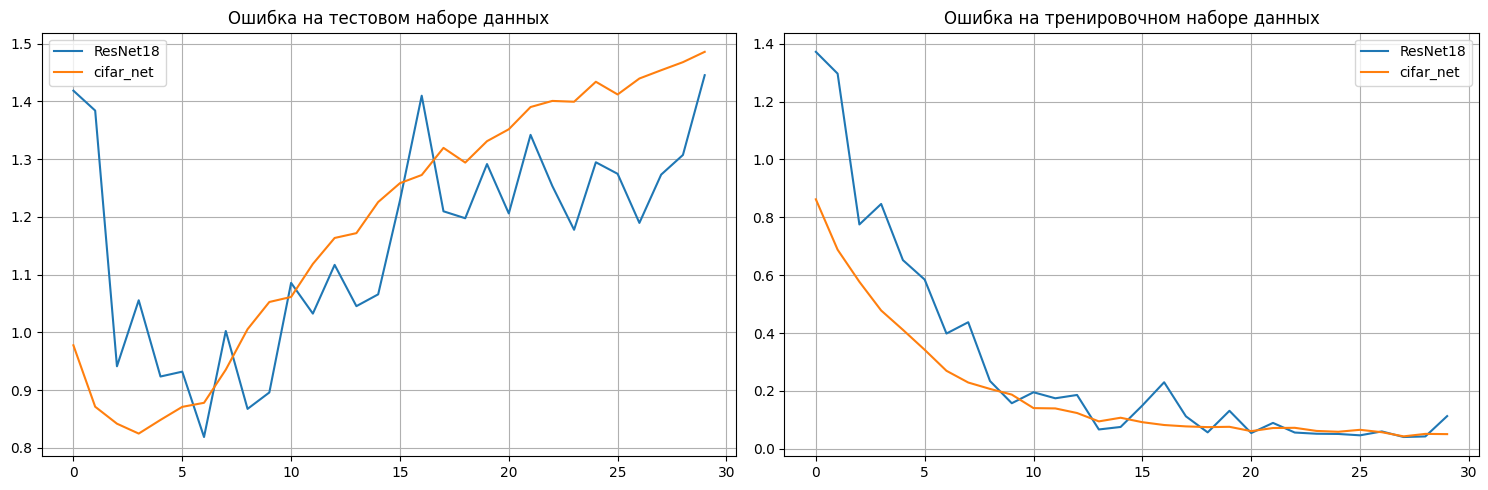

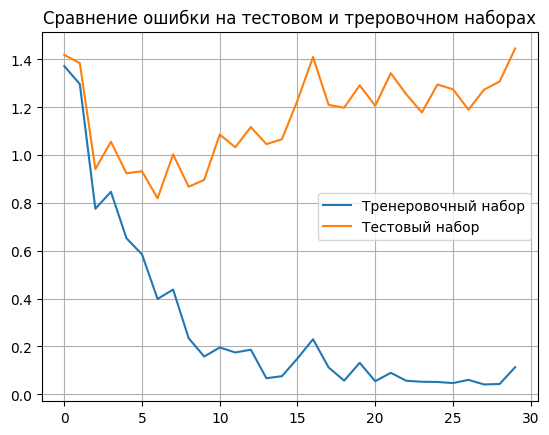

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].set_title('Ошибка на тестовом наборе данных')
for experiment_id in losses_test.keys():
    axes[0].plot(losses_test[experiment_id], label=experiment_id)
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Ошибка на тренировочном наборе данных')
for experiment_id in losses_train.keys():
    axes[1].plot(losses_train[experiment_id], label=experiment_id)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

plt.title('Сравнение ошибки на тестовом и треровочном наборах')
plt.plot(losses_train["cifar_net"], label="Тренеровочный набор")
plt.plot(losses_test["cifar_net"], label="Тестовый набор")
plt.legend()
plt.grid(True)
plt.show()